<a href="https://colab.research.google.com/github/yl13340-dev/Data-Science-Bootcamp-Section-1-/blob/main/European_countries_Nate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

# This will open a file selection dialog.
uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')


Saving sentimentdataset_cleaned.csv to sentimentdataset_cleaned.csv
User uploaded file "sentimentdataset_cleaned.csv" with length 192597 bytes


In [3]:
# 如果只要唯一的國家名稱
print(df["Country"].unique())


['Usa' 'Canada' 'United Kingdom' 'Australia' 'India' 'France' 'Brazil'
 'Japan' 'Greece' 'Germany' 'Sweden' 'Italy' 'Netherlands' 'South Africa'
 'Spain' 'Portugal' 'Switzerland' 'Austria' 'Belgium' 'Denmark'
 'Czech Republic' 'Jordan' 'Peru' 'Maldives' 'China' 'Cambodia' 'Norway'
 'Colombia' 'Ireland' 'Jamaica' 'Kenya' 'Scotland' 'Thailand']


Alternatively, if your data is on Google Drive, you can mount your Drive and access files directly:


In [4]:
import pandas as pd


# 1. 讀取資料
df = pd.read_csv("sentimentdataset_cleaned.csv")



# 2. 篩選歐洲國家 (這裡先假設 United Kingdom, France, Germany, Italy, Spain 等)
europe_countries = ["United Kingdom", "France", "Greece", "Sweden", "Italy", "Netherlands", "Germany", "Italy", "Spain", "Portugal", "Switzerland", "Austria", "Belgium", "Denmark", "Czech Republic", "Norway", "Ireland", "Scotland"]
df_europe = df[df["Country"].isin(europe_countries)]

# 3. 檢查基本統計
print("歐洲樣本數:", len(df_europe))
print(df_europe[["Retweets","Likes"]].describe())

# 4. 分析特徵與互動的平均值
features = ["Platform","Sentiment","hashtag_count","emoji_count","LengthGroup"]

for col in features:
    summary = df_europe.groupby(col)[["Retweets","Likes"]].mean().reset_index()
    print(f"\n平均互動依據 {col}:")
    print(summary)

# 5. 如果要看相關性
corr = df_europe[["Retweets","Likes","hashtag_count","emoji_count","text_len","word_count"]].corr()
print("\n相關性矩陣:")
print(corr)

歐洲樣本數: 217
         Retweets       Likes
count  217.000000  217.000000
mean    21.714286   43.211982
std      6.200465   12.351010
min      7.000000   15.000000
25%     18.000000   35.000000
50%     22.000000   45.000000
75%     28.000000   55.000000
max     35.000000   70.000000

平均互動依據 Platform:
    Platform   Retweets      Likes
0   Facebook  21.348485  42.621212
1  Instagram  22.918919  45.689189
2    Twitter  20.870130  41.337662

平均互動依據 Sentiment:
                  Sentiment  Retweets  Likes
0          Acceptance            15.0   30.0
1           Accomplishment       28.0   55.0
2             Adoration          22.0   45.0
3           Adrenaline           22.0   45.0
4                Adventure       28.5   57.5
..                      ...       ...    ...
125          Tenderness          25.0   50.0
126                 Thrill       28.0   55.0
127            Thrill            22.0   45.0
128      Thrilling Journey       22.0   45.0
129   Whispers of the Past       35.0   70.0

[

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


# 2. 載入 pandas
import pandas as pd

# 3. 讀取 CSV 檔案
df = pd.read_csv("sentimentdataset_cleaned.csv")

# 4. 確認欄位
print(df.columns)
df.head()



# 建立二元標籤 (High=1, Low=0)
ret_mean = df["Retweets"].mean()
like_mean = df["Likes"].mean()
df["Retweets_bin"] = (df["Retweets"] >= ret_mean).astype(int)
df["Likes_bin"] = (df["Likes"] >= like_mean).astype(int)

# 特徵 (Text, Hashtags, SentimentSimple, Month, emoji_count)
X = df[["Text", "Hashtags", "SentimentSimple", "Month", "emoji_count"]]

# 前處理：文字用 TF-IDF，類別用 OneHot，數值型 (emoji_count) 用 StandardScaler
preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(max_features=500), "Text"),
        ("hashtags", TfidfVectorizer(max_features=200), "Hashtags"),
        ("sentiment", OneHotEncoder(handle_unknown="ignore"), ["SentimentSimple"]),
        ("month", OneHotEncoder(handle_unknown="ignore"), ["Month"]),
        ("emoji", StandardScaler(), ["emoji_count"])
    ]
)

# Logistic Regression pipeline
log_reg = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

# 訓練 & 評估 Retweets 高低
X_train, X_test, y_train, y_test = train_test_split(X, df["Retweets_bin"], test_size=0.2, random_state=42)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print("Retweets classification report:\n", classification_report(y_test, y_pred))

# 訓練 & 評估 Likes 高低
X_train, X_test, y_train, y_test = train_test_split(X, df["Likes_bin"], test_size=0.2, random_state=42)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print("Likes classification report:\n", classification_report(y_test, y_pred))

Index(['Id', 'Text', 'Sentiment', 'Timestamp', 'User', 'Platform', 'Hashtags',
       'Retweets', 'Likes', 'Country', 'Year', 'Month', 'Day', 'Hour',
       'text_len', 'word_count', 'hashtag_count', 'emoji_count',
       'SentimentSimple', 'Sentiment_norm', 'TextLength', 'LengthGroup'],
      dtype='object')
Retweets classification report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67        67
           1       0.72      0.72      0.72        80

    accuracy                           0.70       147
   macro avg       0.70      0.70      0.70       147
weighted avg       0.70      0.70      0.70       147

Likes classification report:
               precision    recall  f1-score   support

           0       0.68      0.70      0.69        66
           1       0.75      0.73      0.74        81

    accuracy                           0.71       147
   macro avg       0.71      0.71      0.71       147
weighted avg       0.72    

In [6]:
# 1. 匯入套件
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# 2. 讀取 CSV 檔案
df = pd.read_csv("sentimentdataset_cleaned.csv")

# 3. 建立二元標籤 (High=1, Low=0)
ret_mean = df["Retweets"].mean()
like_mean = df["Likes"].mean()
df["Retweets_bin"] = (df["Retweets"] >= ret_mean).astype(int)
df["Likes_bin"] = (df["Likes"] >= like_mean).astype(int)

# 4. 特徵欄位
X = df[["Text", "Hashtags", "SentimentSimple", "Month", "emoji_count"]]

# 5. 前處理：文字用 TF-IDF，類別用 OneHot，數值型用 StandardScaler
preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(max_features=500), "Text"),
        ("hashtags", TfidfVectorizer(max_features=200), "Hashtags"),
        ("sentiment", OneHotEncoder(handle_unknown="ignore"), ["SentimentSimple"]),
        ("month", OneHotEncoder(handle_unknown="ignore"), ["Month"]),
        ("emoji", StandardScaler(), ["emoji_count"])
    ]
)

# 6. 建立兩個 Logistic Regression pipeline
log_reg_ret = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

log_reg_like = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

# 7. 訓練 & 評估 Retweets 模型
X_train, X_test, y_train, y_test = train_test_split(X, df["Retweets_bin"], test_size=0.2, random_state=42)
log_reg_ret.fit(X_train, y_train)
y_pred = log_reg_ret.predict(X_test)
print("Retweets classification report:\n", classification_report(y_test, y_pred))
print("Retweets confusion matrix:\n", confusion_matrix(y_test, y_pred))

# 8. 訓練 & 評估 Likes 模型
X_train, X_test, y_train, y_test = train_test_split(X, df["Likes_bin"], test_size=0.2, random_state=42)
log_reg_like.fit(X_train, y_train)
y_pred = log_reg_like.predict(X_test)
print("Likes classification report:\n", classification_report(y_test, y_pred))
print("Likes confusion matrix:\n", confusion_matrix(y_test, y_pred))

Retweets classification report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67        67
           1       0.72      0.72      0.72        80

    accuracy                           0.70       147
   macro avg       0.70      0.70      0.70       147
weighted avg       0.70      0.70      0.70       147

Retweets confusion matrix:
 [[45 22]
 [22 58]]
Likes classification report:
               precision    recall  f1-score   support

           0       0.68      0.70      0.69        66
           1       0.75      0.73      0.74        81

    accuracy                           0.71       147
   macro avg       0.71      0.71      0.71       147
weighted avg       0.72      0.71      0.71       147

Likes confusion matrix:
 [[46 20]
 [22 59]]


In [8]:
# 假設歐洲國家名單 (你可以依資料集調整)
europe_countries = ["United Kingdom", "France", "Greece", "Sweden", "Italy", "Netherlands", "Germany", "Italy", "Spain", "Portugal", "Switzerland", "Austria", "Belgium", "Denmark", "Czech Republic", "Norway", "Ireland", "Scotland"]

# 篩選歐洲樣本
df_europe = df[df["Country"].isin(europe_countries)]

# 建立二元標籤 (High=1, Low=0)
ret_mean = df_europe["Retweets"].mean()
like_mean = df_europe["Likes"].mean()
df_europe["Retweets_bin"] = (df_europe["Retweets"] >= ret_mean).astype(int)
df_europe["Likes_bin"] = (df_europe["Likes"] >= like_mean).astype(int)

# 特徵
X = df_europe[["Text", "Hashtags", "SentimentSimple", "Month", "emoji_count"]]

# 前處理
preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(max_features=500), "Text"),
        ("hashtags", TfidfVectorizer(max_features=200), "Hashtags"),
        ("sentiment", OneHotEncoder(handle_unknown="ignore"), ["SentimentSimple"]),
        ("month", OneHotEncoder(handle_unknown="ignore"), ["Month"]),
        ("emoji", StandardScaler(), ["emoji_count"])
    ]
)

# 建立 pipeline
log_reg_ret = Pipeline(steps=[("preprocess", preprocessor),
                              ("classifier", LogisticRegression(max_iter=1000))])

log_reg_like = Pipeline(steps=[("preprocess", preprocessor),
                               ("classifier", LogisticRegression(max_iter=1000))])

# 訓練 & 評估 Retweets 模型 (歐洲樣本)
X_train, X_test, y_train, y_test = train_test_split(X, df_europe["Retweets_bin"], test_size=0.2, random_state=42)
log_reg_ret.fit(X_train, y_train)
y_pred = log_reg_ret.predict(X_test)
print("Retweets classification report (Europe):\n", classification_report(y_test, y_pred))

# 訓練 & 評估 Likes 模型 (歐洲樣本)
X_train, X_test, y_train, y_test = train_test_split(X, df_europe["Likes_bin"], test_size=0.2, random_state=42)
log_reg_like.fit(X_train, y_train)
y_pred = log_reg_like.predict(X_test)
print("Likes classification report (Europe):\n", classification_report(y_test, y_pred))

/tmp/ipython-input-3710437676.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_europe["Retweets_bin"] = (df_europe["Retweets"] >= ret_mean).astype(int)
/tmp/ipython-input-3710437676.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_europe["Likes_bin"] = (df_europe["Likes"] >= like_mean).astype(int)


Retweets classification report (Europe):
               precision    recall  f1-score   support

           0       0.68      0.57      0.62        23
           1       0.60      0.71      0.65        21

    accuracy                           0.64        44
   macro avg       0.64      0.64      0.64        44
weighted avg       0.64      0.64      0.63        44

Likes classification report (Europe):
               precision    recall  f1-score   support

           0       0.80      0.64      0.71        25
           1       0.62      0.79      0.70        19

    accuracy                           0.70        44
   macro avg       0.71      0.71      0.70        44
weighted avg       0.72      0.70      0.71        44



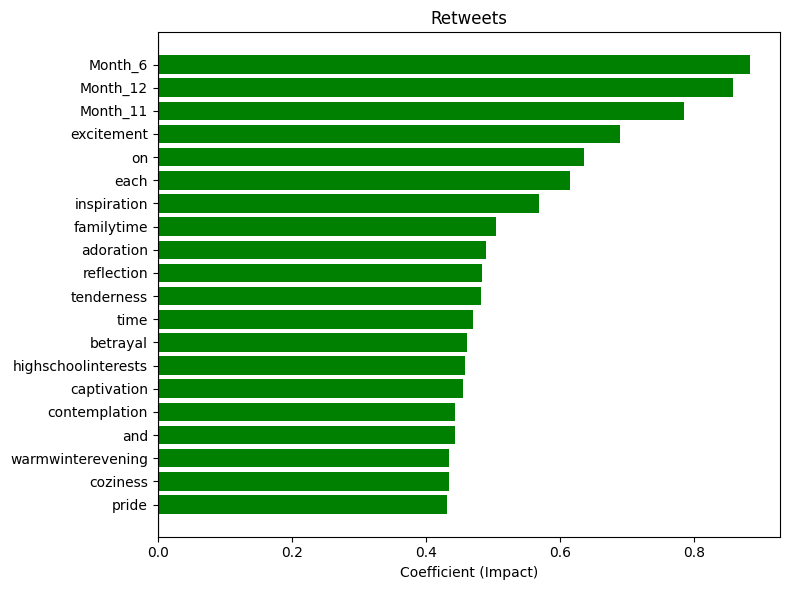


Top 20 features influencing Retweets:
Month_6: 0.884
Month_12: 0.859
Month_11: 0.785
excitement: 0.690
on: 0.635
each: 0.615
inspiration: 0.568
familytime: 0.504
adoration: 0.490
reflection: 0.483
tenderness: 0.482
time: 0.470
betrayal: 0.461
highschoolinterests: 0.459
captivation: 0.455
contemplation: 0.444
and: 0.443
warmwinterevening: 0.434
coziness: 0.434
pride: 0.431


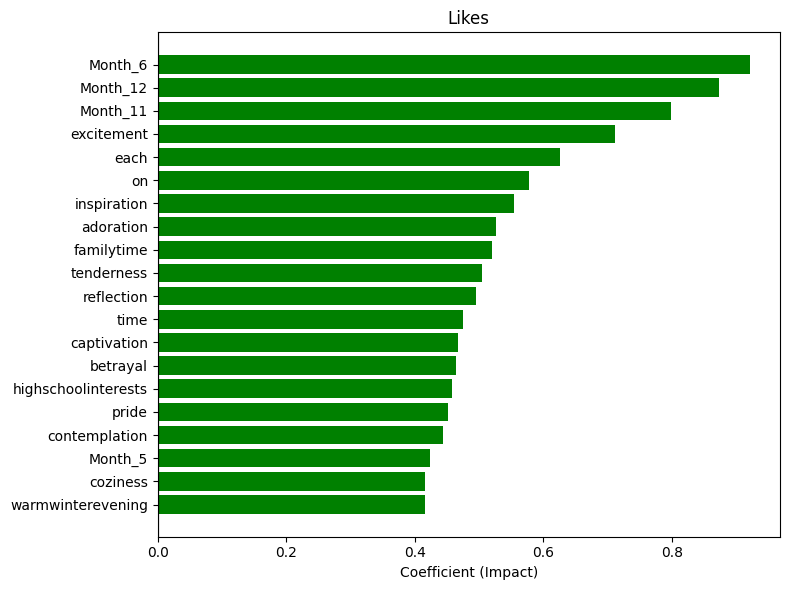


Top 20 features influencing Likes:
Month_6: 0.922
Month_12: 0.874
Month_11: 0.798
excitement: 0.712
each: 0.625
on: 0.577
inspiration: 0.553
adoration: 0.526
familytime: 0.520
tenderness: 0.504
reflection: 0.495
time: 0.475
captivation: 0.467
betrayal: 0.464
highschoolinterests: 0.458
pride: 0.451
contemplation: 0.444
Month_5: 0.423
coziness: 0.416
warmwinterevening: 0.416


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# 取得完整特徵名稱
feature_names = []
feature_names.extend(preprocessor.named_transformers_["text"].get_feature_names_out())
feature_names.extend(preprocessor.named_transformers_["hashtags"].get_feature_names_out())
feature_names.extend(preprocessor.named_transformers_["sentiment"].get_feature_names_out(["SentimentSimple"]))
feature_names.extend(preprocessor.named_transformers_["month"].get_feature_names_out(["Month"]))
feature_names.append("emoji_count")

def plot_sorted_features(model, feature_names, title, top_n=20):
    # 取出係數
    coef = model.named_steps["classifier"].coef_[0]
    df = pd.DataFrame({"Feature": feature_names, "Coefficient": coef})

    # 依照數值大小排序 (由正到負)
    df = df.sort_values("Coefficient", ascending=False).head(top_n)

    # 顏色：正值綠色，負值紅色
    colors = df["Coefficient"].apply(lambda x: "green" if x > 0 else "red")

    # 繪圖
    plt.figure(figsize=(8,6))
    plt.barh(df["Feature"], df["Coefficient"], color=colors)
    plt.axvline(0, color="black", linewidth=0.8)
    plt.title(title)
    plt.xlabel("Coefficient (Impact)")
    plt.gca().invert_yaxis()  # 讓最大值在上方
    plt.tight_layout()
    plt.show()

    # 印出排序結果
    print(f"\nTop {top_n} features influencing {title}:")
    for i, row in df.iterrows():
        print(f"{row['Feature']}: {row['Coefficient']:.3f}")

# 繪製 Retweets 特徵影響
plot_sorted_features(log_reg_ret, feature_names, "Retweets", top_n=20)

# 繪製 Likes 特徵影響
plot_sorted_features(log_reg_like, feature_names, "Likes", top_n=20)

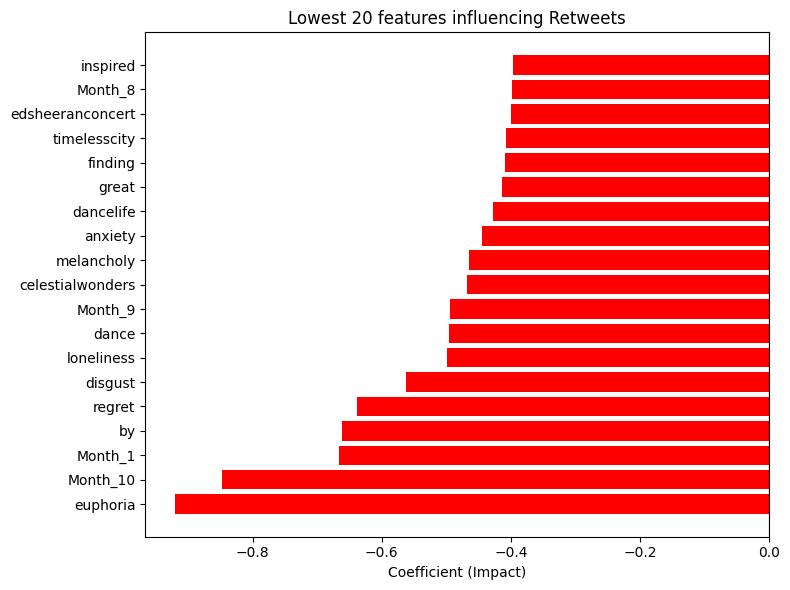


Lowest 20 features influencing Retweets:
euphoria: -0.920
Month_10: -0.848
Month_1: -0.666
by: -0.661
regret: -0.638
disgust: -0.563
loneliness: -0.499
dance: -0.497
Month_9: -0.494
celestialwonders: -0.468
melancholy: -0.465
anxiety: -0.445
dancelife: -0.427
great: -0.414
finding: -0.409
timelesscity: -0.407
euphoria: -0.403
edsheeranconcert: -0.400
Month_8: -0.398
inspired: -0.397


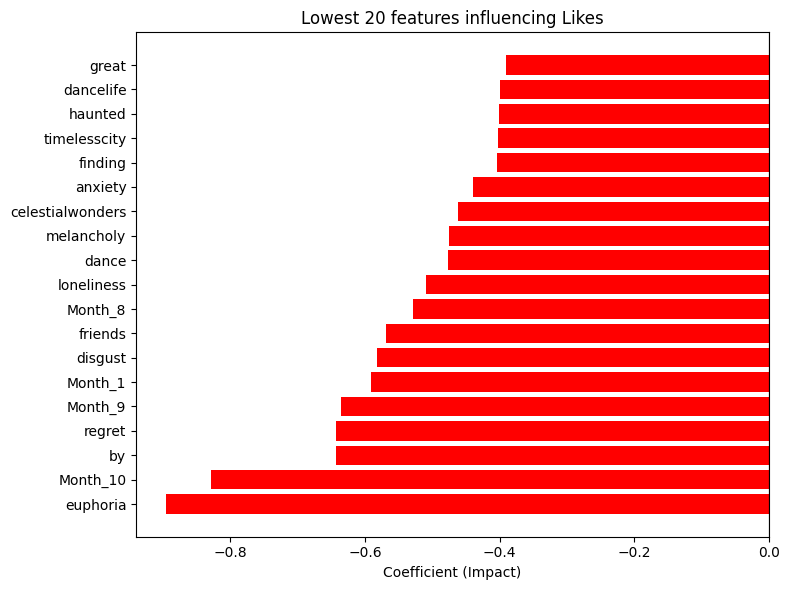


Lowest 20 features influencing Likes:
euphoria: -0.895
Month_10: -0.829
by: -0.643
regret: -0.642
Month_9: -0.636
Month_1: -0.591
disgust: -0.582
friends: -0.569
Month_8: -0.529
loneliness: -0.510
dance: -0.477
melancholy: -0.475
celestialwonders: -0.462
anxiety: -0.440
finding: -0.404
timelesscity: -0.403
haunted: -0.402
dancelife: -0.399
euphoria: -0.392
great: -0.390


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 取得完整特徵名稱
feature_names = []
feature_names.extend(preprocessor.named_transformers_["text"].get_feature_names_out())
feature_names.extend(preprocessor.named_transformers_["hashtags"].get_feature_names_out())
feature_names.extend(preprocessor.named_transformers_["sentiment"].get_feature_names_out(["SentimentSimple"]))
feature_names.extend(preprocessor.named_transformers_["month"].get_feature_names_out(["Month"]))
feature_names.append("emoji_count")

def plot_lowest_features(model, feature_names, title, bottom_n=20):
    # 取出係數
    coef = model.named_steps["classifier"].coef_[0]
    df = pd.DataFrame({"Feature": feature_names, "Coefficient": coef})

    # 依照數值大小排序 (由負到正)，取最低 N 個
    df = df.sort_values("Coefficient", ascending=True).head(bottom_n)

    # 顏色：正值綠色，負值紅色
    colors = df["Coefficient"].apply(lambda x: "green" if x > 0 else "red")

    # 繪圖
    plt.figure(figsize=(8,6))
    plt.barh(df["Feature"], df["Coefficient"], color=colors)
    plt.axvline(0, color="black", linewidth=0.8)
    plt.title(f"Lowest {bottom_n} features influencing {title}")
    plt.xlabel("Coefficient (Impact)")
    plt.tight_layout()
    plt.show()

    # 印出排序結果
    print(f"\nLowest {bottom_n} features influencing {title}:")
    for i, row in df.iterrows():
        print(f"{row['Feature']}: {row['Coefficient']:.3f}")

# 顯示 Retweets 最低 20 特徵
plot_lowest_features(log_reg_ret, feature_names, "Retweets", bottom_n=20)

# 顯示 Likes 最低 20 特徵
plot_lowest_features(log_reg_like, feature_names, "Likes", bottom_n=20)


Saving sentimentdataset_cleaned.csv to sentimentdataset_cleaned (1).csv
User uploaded file "sentimentdataset_cleaned (1).csv" with length 192597 bytes
['Usa' 'Canada' 'United Kingdom' 'Australia' 'India' 'France' 'Brazil'
 'Japan' 'Greece' 'Germany' 'Sweden' 'Italy' 'Netherlands' 'South Africa'
 'Spain' 'Portugal' 'Switzerland' 'Austria' 'Belgium' 'Denmark'
 'Czech Republic' 'Jordan' 'Peru' 'Maldives' 'China' 'Cambodia' 'Norway'
 'Colombia' 'Ireland' 'Jamaica' 'Kenya' 'Scotland' 'Thailand']

===== Analysis: All Countries =====
Sample size: 732
         Retweets       Likes
count  732.000000  732.000000
mean    21.508197   42.901639
std      7.061286   14.089848
min      5.000000   10.000000
25%     17.750000   34.750000
50%     22.000000   43.000000
75%     25.000000   50.000000
max     40.000000   80.000000

Average interactions by Platform:
    Platform   Retweets      Likes
0   Facebook  20.969697  41.870130
1  Instagram  22.600775  45.089147
2    Twitter  20.860082  41.559671

Aver

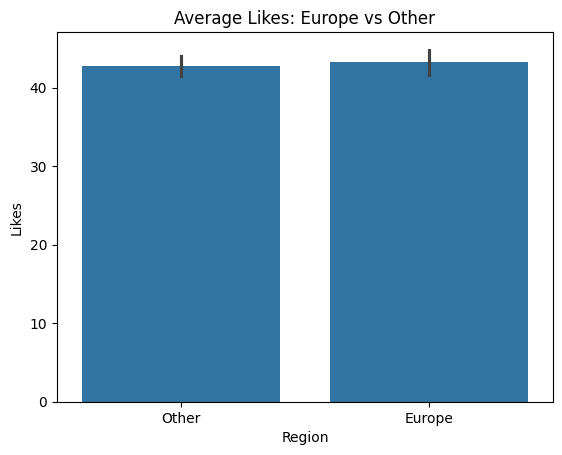

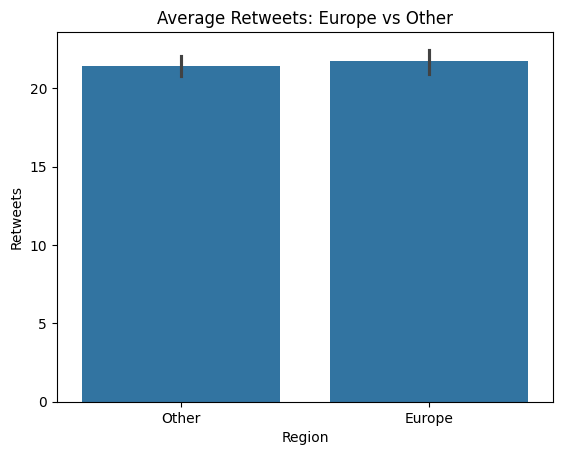

In [11]:
import pandas as pd
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Upload file
uploaded = files.upload()
for fn in uploaded.keys():
    print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

# 2. Read dataset
df = pd.read_csv("sentimentdataset_cleaned.csv")

# Show unique country names
print(df["Country"].unique())

# 3. Define European countries
europe_countries = [
    "United Kingdom", "France", "Greece", "Sweden", "Italy", "Netherlands",
    "Germany", "Spain", "Portugal", "Switzerland", "Austria", "Belgium",
    "Denmark", "Czech Republic", "Norway", "Ireland", "Scotland"
]

df_europe = df[df["Country"].isin(europe_countries)]

# 4. Analysis function
def analyze_group(df, group_name="All Countries"):
    print(f"\n===== Analysis: {group_name} =====")
    print(f"Sample size: {len(df)}")
    print(df[["Retweets", "Likes"]].describe())

    features = ["Platform", "Sentiment", "hashtag_count", "emoji_count", "LengthGroup"]
    for col in features:
        summary = df.groupby(col)[["Retweets", "Likes"]].mean().reset_index()
        print(f"\nAverage interactions by {col}:")
        print(summary)

    corr = df[["Retweets", "Likes", "hashtag_count", "emoji_count", "text_len", "word_count"]].corr()
    print("\nCorrelation matrix:")
    print(corr)

# 5. Run analysis for all countries and Europe
analyze_group(df, "All Countries")
analyze_group(df_europe, "Europe")

# 6. Visualization: Europe vs Other
df["Region"] = df["Country"].apply(lambda x: "Europe" if x in europe_countries else "Other")

sns.barplot(data=df, x="Region", y="Likes")
plt.title("Average Likes: Europe vs Other")
plt.show()

sns.barplot(data=df, x="Region", y="Retweets")
plt.title("Average Retweets: Europe vs Other")
plt.show()


In [12]:
# 假設歐洲國家名單 (你可以依資料集調整)
europe_countries = ["United Kingdom", "France", "Greece", "Sweden", "Italy", "Netherlands", "Germany", "Italy", "Spain", "Portugal", "Switzerland", "Austria", "Belgium", "Denmark", "Czech Republic", "Norway", "Ireland", "Scotland"]

# 篩選歐洲樣本
df_europe = df[df["Country"].isin(europe_countries)]

# 建立二元標籤 (High=1, Low=0)
ret_mean = df_europe["Retweets"].mean()
like_mean = df_europe["Likes"].mean()
df_europe["Retweets_bin"] = (df_europe["Retweets"] >= ret_mean).astype(int)
df_europe["Likes_bin"] = (df_europe["Likes"] >= like_mean).astype(int)

# 特徵
X = df_europe[["Text", "Hashtags", "SentimentSimple", "Month", "emoji_count"]]

# 前處理
preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(max_features=500), "Text"),
        ("hashtags", TfidfVectorizer(max_features=200), "Hashtags"),
        ("sentiment", OneHotEncoder(handle_unknown="ignore"), ["SentimentSimple"]),
        ("month", OneHotEncoder(handle_unknown="ignore"), ["Month"]),
        ("emoji", StandardScaler(), ["emoji_count"])
    ]
)

# 建立 pipeline
log_reg_ret = Pipeline(steps=[("preprocess", preprocessor),
                              ("classifier", LogisticRegression(max_iter=1000))])

log_reg_like = Pipeline(steps=[("preprocess", preprocessor),
                               ("classifier", LogisticRegression(max_iter=1000))])

# 訓練 & 評估 Retweets 模型 (歐洲樣本)
X_train, X_test, y_train, y_test = train_test_split(X, df_europe["Retweets_bin"], test_size=0.2, random_state=42)
log_reg_ret.fit(X_train, y_train)
y_pred = log_reg_ret.predict(X_test)
print("Retweets classification report (Europe):\n", classification_report(y_test, y_pred))

# 訓練 & 評估 Likes 模型 (歐洲樣本)
X_train, X_test, y_train, y_test = train_test_split(X, df_europe["Likes_bin"], test_size=0.2, random_state=42)
log_reg_like.fit(X_train, y_train)
y_pred = log_reg_like.predict(X_test)
print("Likes classification report (Europe):\n", classification_report(y_test, y_pred))

Retweets classification report (Europe):
               precision    recall  f1-score   support

           0       0.68      0.57      0.62        23
           1       0.60      0.71      0.65        21

    accuracy                           0.64        44
   macro avg       0.64      0.64      0.64        44
weighted avg       0.64      0.64      0.63        44

Likes classification report (Europe):
               precision    recall  f1-score   support

           0       0.80      0.64      0.71        25
           1       0.62      0.79      0.70        19

    accuracy                           0.70        44
   macro avg       0.71      0.71      0.70        44
weighted avg       0.72      0.70      0.71        44



/tmp/ipython-input-3710437676.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_europe["Retweets_bin"] = (df_europe["Retweets"] >= ret_mean).astype(int)
/tmp/ipython-input-3710437676.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_europe["Likes_bin"] = (df_europe["Likes"] >= like_mean).astype(int)


In [14]:
# 特徵 (新增 word_count, hashtag_count)
X = df_europe[[
    "Text", "Hashtags", "SentimentSimple", "Month",
    "emoji_count", "word_count", "hashtag_count"
]]

# 前處理
preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(max_features=500), "Text"),
        ("hashtags", TfidfVectorizer(max_features=200), "Hashtags"),
        ("sentiment", OneHotEncoder(handle_unknown="ignore"), ["SentimentSimple"]),
        ("month", OneHotEncoder(handle_unknown="ignore"), ["Month"]),
        ("emoji", StandardScaler(), ["emoji_count"]),
        ("word_count", StandardScaler(), ["word_count"]),
        ("hashtag_count", StandardScaler(), ["hashtag_count"])
    ]
)

# 建立 pipeline
log_reg_ret = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

log_reg_like = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

# 訓練 & 評估 Retweets 模型 (歐洲樣本)
X_train, X_test, y_train, y_test = train_test_split(X, df_europe["Retweets_bin"], test_size=0.2, random_state=42)
log_reg_ret.fit(X_train, y_train)
y_pred = log_reg_ret.predict(X_test)
print("Retweets classification report (Europe):\n", classification_report(y_test, y_pred))

# 訓練 & 評估 Likes 模型 (歐洲樣本)
X_train, X_test, y_train, y_test = train_test_split(X, df_europe["Likes_bin"], test_size=0.2, random_state=42)
log_reg_like.fit(X_train, y_train)
y_pred = log_reg_like.predict(X_test)
print("Likes classification report (Europe):\n", classification_report(y_test, y_pred))

Retweets classification report (Europe):
               precision    recall  f1-score   support

           0       0.83      0.65      0.73        23
           1       0.69      0.86      0.77        21

    accuracy                           0.75        44
   macro avg       0.76      0.75      0.75        44
weighted avg       0.77      0.75      0.75        44

Likes classification report (Europe):
               precision    recall  f1-score   support

           0       0.85      0.68      0.76        25
           1       0.67      0.84      0.74        19

    accuracy                           0.75        44
   macro avg       0.76      0.76      0.75        44
weighted avg       0.77      0.75      0.75        44



In [15]:
# 特徵 (新增 word_count, hashtag_count, text_len, LengthGroup)
X = df_europe[[
    "Text", "Hashtags", "SentimentSimple", "Month",
    "emoji_count", "word_count", "hashtag_count",
    "text_len", "LengthGroup"
]]

# 前處理
preprocessor = ColumnTransformer(
    transformers=[
        ("text", TfidfVectorizer(max_features=500), "Text"),
        ("hashtags", TfidfVectorizer(max_features=200), "Hashtags"),
        ("sentiment", OneHotEncoder(handle_unknown="ignore"), ["SentimentSimple"]),
        ("month", OneHotEncoder(handle_unknown="ignore"), ["Month"]),
        ("emoji", StandardScaler(), ["emoji_count"]),
        ("word_count", StandardScaler(), ["word_count"]),
        ("hashtag_count", StandardScaler(), ["hashtag_count"]),
        ("text_len", StandardScaler(), ["text_len"]),
        ("length_group", OneHotEncoder(handle_unknown="ignore"), ["LengthGroup"])
    ]
)

# 建立 pipeline
log_reg_ret = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

log_reg_like = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])
# 訓練 & 評估 Retweets 模型 (歐洲樣本)
X_train, X_test, y_train, y_test = train_test_split(X, df_europe["Retweets_bin"], test_size=0.2, random_state=42)
log_reg_ret.fit(X_train, y_train)
y_pred = log_reg_ret.predict(X_test)
print("Retweets classification report (Europe):\n", classification_report(y_test, y_pred))

# 訓練 & 評估 Likes 模型 (歐洲樣本)
X_train, X_test, y_train, y_test = train_test_split(X, df_europe["Likes_bin"], test_size=0.2, random_state=42)
log_reg_like.fit(X_train, y_train)
y_pred = log_reg_like.predict(X_test)
print("Likes classification report (Europe):\n", classification_report(y_test, y_pred))

Retweets classification report (Europe):
               precision    recall  f1-score   support

           0       0.76      0.70      0.73        23
           1       0.70      0.76      0.73        21

    accuracy                           0.73        44
   macro avg       0.73      0.73      0.73        44
weighted avg       0.73      0.73      0.73        44

Likes classification report (Europe):
               precision    recall  f1-score   support

           0       0.82      0.72      0.77        25
           1       0.68      0.79      0.73        19

    accuracy                           0.75        44
   macro avg       0.75      0.75      0.75        44
weighted avg       0.76      0.75      0.75        44

